In [49]:
import math, random, pickle, os, copy, itertools, sys, gpytorch
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)
sys.path.insert(1, os.path.join(PROJECT_DIR, 'utils'))

from utils.trained_svgd import serialize_model, TrainedSVGD
from utils.search_models import handle_search_space, find_best_model, best_lin_reg
from third_party.Synthetic_PV_Profiles import CityPV_UniModal, CityPV_MultiModal
from third_party.Synthetic_PV_Profiles import get_available_modules, get_available_inverters
from utils.assistive_functions import visualize_pv, print_gp_prior_params
from meta_learn import GPRegressionLearned, GPRegressionMetaLearned, GPRegressionMetaLearnedSVGD

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

exp_name = 'PV_UniModal'

# Load data
* vary the tilt of the installation and the azimuthal orientation
* same coordinates and altitude of central Lausanne

In [50]:
# ----- SET UP LOGGER -----
now = datetime.now().strftime("%m_%d_%H")
filename_env  = os.getcwd() + "/../PV/saved_results/" + exp_name + "_env"
filename_log  = os.getcwd() + "/../PV/saved_results/" + exp_name + now + ".log"
filename_save = os.getcwd() + "/../PV/saved_results/" + exp_name + "_models"
filename_data = os.getcwd() + "/../PV/saved_results/" + exp_name + "_clients_data"
#logging.basicConfig(filename=filename_log, format='%(asctime)s %(message)s', filemode='w')
#logger=logging.getLogger('PV_Lausanne')
#logger.setLevel(logging.DEBUG)

In [56]:
generate_data = True
normalize_data = True
load_saved_models = True
feature_dim = 2
methods =['benchmark'] # list of methods to run. subset of ['baseline', 'benchmark', 'fedavg', 'ours'] 
verbose=True

In [52]:
# Generate data
city_names = ['Lausanne']
# x_std: std in variations of x among houses
# x_dev: multiplied by range of x or x to find std
if generate_data:
    num_clients=24
    env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 20, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.8,
            'module_name': get_available_modules('sandia')[0:num_clients], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:num_clients], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':None, 'months':[3,4], 'hours':np.arange(7, 17),
            'train_frac_2y': 0.75, 'm_train_red': 40, 'm_valid_red': 40}

    # FL info
    env_dict['weight_modes'] = [1/env_dict['num_modes']] * env_dict['num_modes']
    env_dict['num_clients_per_mode'] = [int(env_dict['weight_modes'][i]*env_dict['num_clients']) for i in np.arange(env_dict['num_modes'])]
    env_dict['num_clients'] = sum(env_dict['num_clients_per_mode'])

    env_dict['info'] = '{:2.0f} households at '.format(env_dict['num_clients'])+ " ".join(env_dict['city_names']) + ' - '
    for key in ['tilt_std', 'az_std', 'weather_dev', 'irrad_std', 'altitude_dev']:
        env_dict['info'] += key+': {:.1f} '.format(env_dict[key])
    print('\n'+env_dict['info'])

    # --- create task env ---
    task_environment = CityPV_MultiModal(city_names=env_dict['city_names'],
                 tilt_mean=None, az_mean=None, tilt_std=env_dict['tilt_std'], az_std=env_dict['az_std'],
                 weather_dev=env_dict['weather_dev'], irrad_std=env_dict['irrad_std'], altitude_dev=env_dict['altitude_dev'],
                 random_state=random_state) 
    clients_data_full, clients_ts_2018, clients_ts_2019 = task_environment.simulate_pv(
                                                        num_clients_per_mode=env_dict['num_clients_per_mode'], 
                                                        module_name=env_dict['module_name'], inverter_name=env_dict['inverter_name'],
                                                        lags=env_dict['lags'], months=env_dict['months'], hours=env_dict['hours']) 
    

    # properties of task env that might have changed
    env_dict['feature_names'] = task_environment.feature_names
    env_dict['months'] = task_environment.months
    env_dict['hours'] = task_environment.hours
    env_dict['lags'] = task_environment.lags

    # --- data for benchmark ---
    shuffle=False
    clients_data_2y = [None]*env_dict['num_clients']
    for client_num in np.arange(env_dict['num_clients']):
        x_train, y_train, x_valid, y_valid = clients_data_full[client_num]
        x_all = np.concatenate((x_train, x_valid), axis=0)
        y_all = np.concatenate((y_train, y_valid), axis=0)
        if shuffle:
            train_inds = random_state.choice(np.arange(x_all.shape[0]), 
                                            size=int(x_all.shape[0]*env_dict['train_frac_2y']), replace=False)
        else: # use the last portion for validation
            train_inds = np.arange(int(x_all.shape[0]*env_dict['train_frac_2y']))
        valid_inds = list(set(np.arange(x_all.shape[0])) - set(train_inds))
        # divide again and put back
        clients_data_2y[client_num] = (x_all[train_inds, :], y_all[train_inds, :], 
                                       x_all[valid_inds, :], y_all[valid_inds, :])

    # --- data reduced ----
    clients_data_red = [None] * env_dict['num_clients']
    for client_num in np.arange(env_dict['num_clients']):
        data = clients_data_full[client_num]
        # randomly select train_inds and valid_inds
        train_inds = random_state.choice(np.arange(data[0].shape[0]), 
                                        size=env_dict['m_train_red'], replace=False)
        valid_inds = random_state.choice(np.arange(data[3].shape[0]), 
                                        size=env_dict['m_valid_red'], replace=False)
        # new train and validation data
        clients_data_red[client_num] = (data[0][train_inds, :], data[1][train_inds],
                                    data[2][valid_inds, :], data[3][valid_inds])
        # mark samples used for train or validation
        is_test_2018 = [True]*len(clients_ts_2018[client_num].index) # mark all as test
        for i in train_inds:
            is_test_2018[i] = False            # train points are not test
        is_test_2019 = [True]*len(clients_ts_2019[client_num].index) # mark all as test
        for i in valid_inds:
            is_test_2019[i] = False            # valid points are not test
        clients_ts_2018[client_num]['is_test'] = is_test_2018 
        clients_ts_2019[client_num]['is_test'] = is_test_2019 


    # Save
    env_dict['clients_ts_2018']=clients_ts_2018
    env_dict['clients_ts_2019']=clients_ts_2019
    env_dict['clients_data_2y']=clients_data_2y
    env_dict['clients_data_red']=clients_data_red
    env_dict['clients_data_full']=clients_data_full
    env_dict['clients_config']=task_environment.clients_config
    
    # dump env dict
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])
    print(msg)
    #logger.info(msg)
    del client_num
    generate_data = False
else:
    file = open(filename_env, 'rb')
    env_dict = pickle.load(file)
    msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
    print(msg)
    #logger.info(msg)
# close the file
file.close()


num_clients = env_dict['num_clients'] 
num_features = len(env_dict['feature_names'])


24 households at Lausanne - tilt_std: 5.0 az_std: 20.0 weather_dev: 0.1 irrad_std: 0.2 altitude_dev: 0.1 
[INFO] generating data for Lausanne
[INFO] saved data for 24 clients


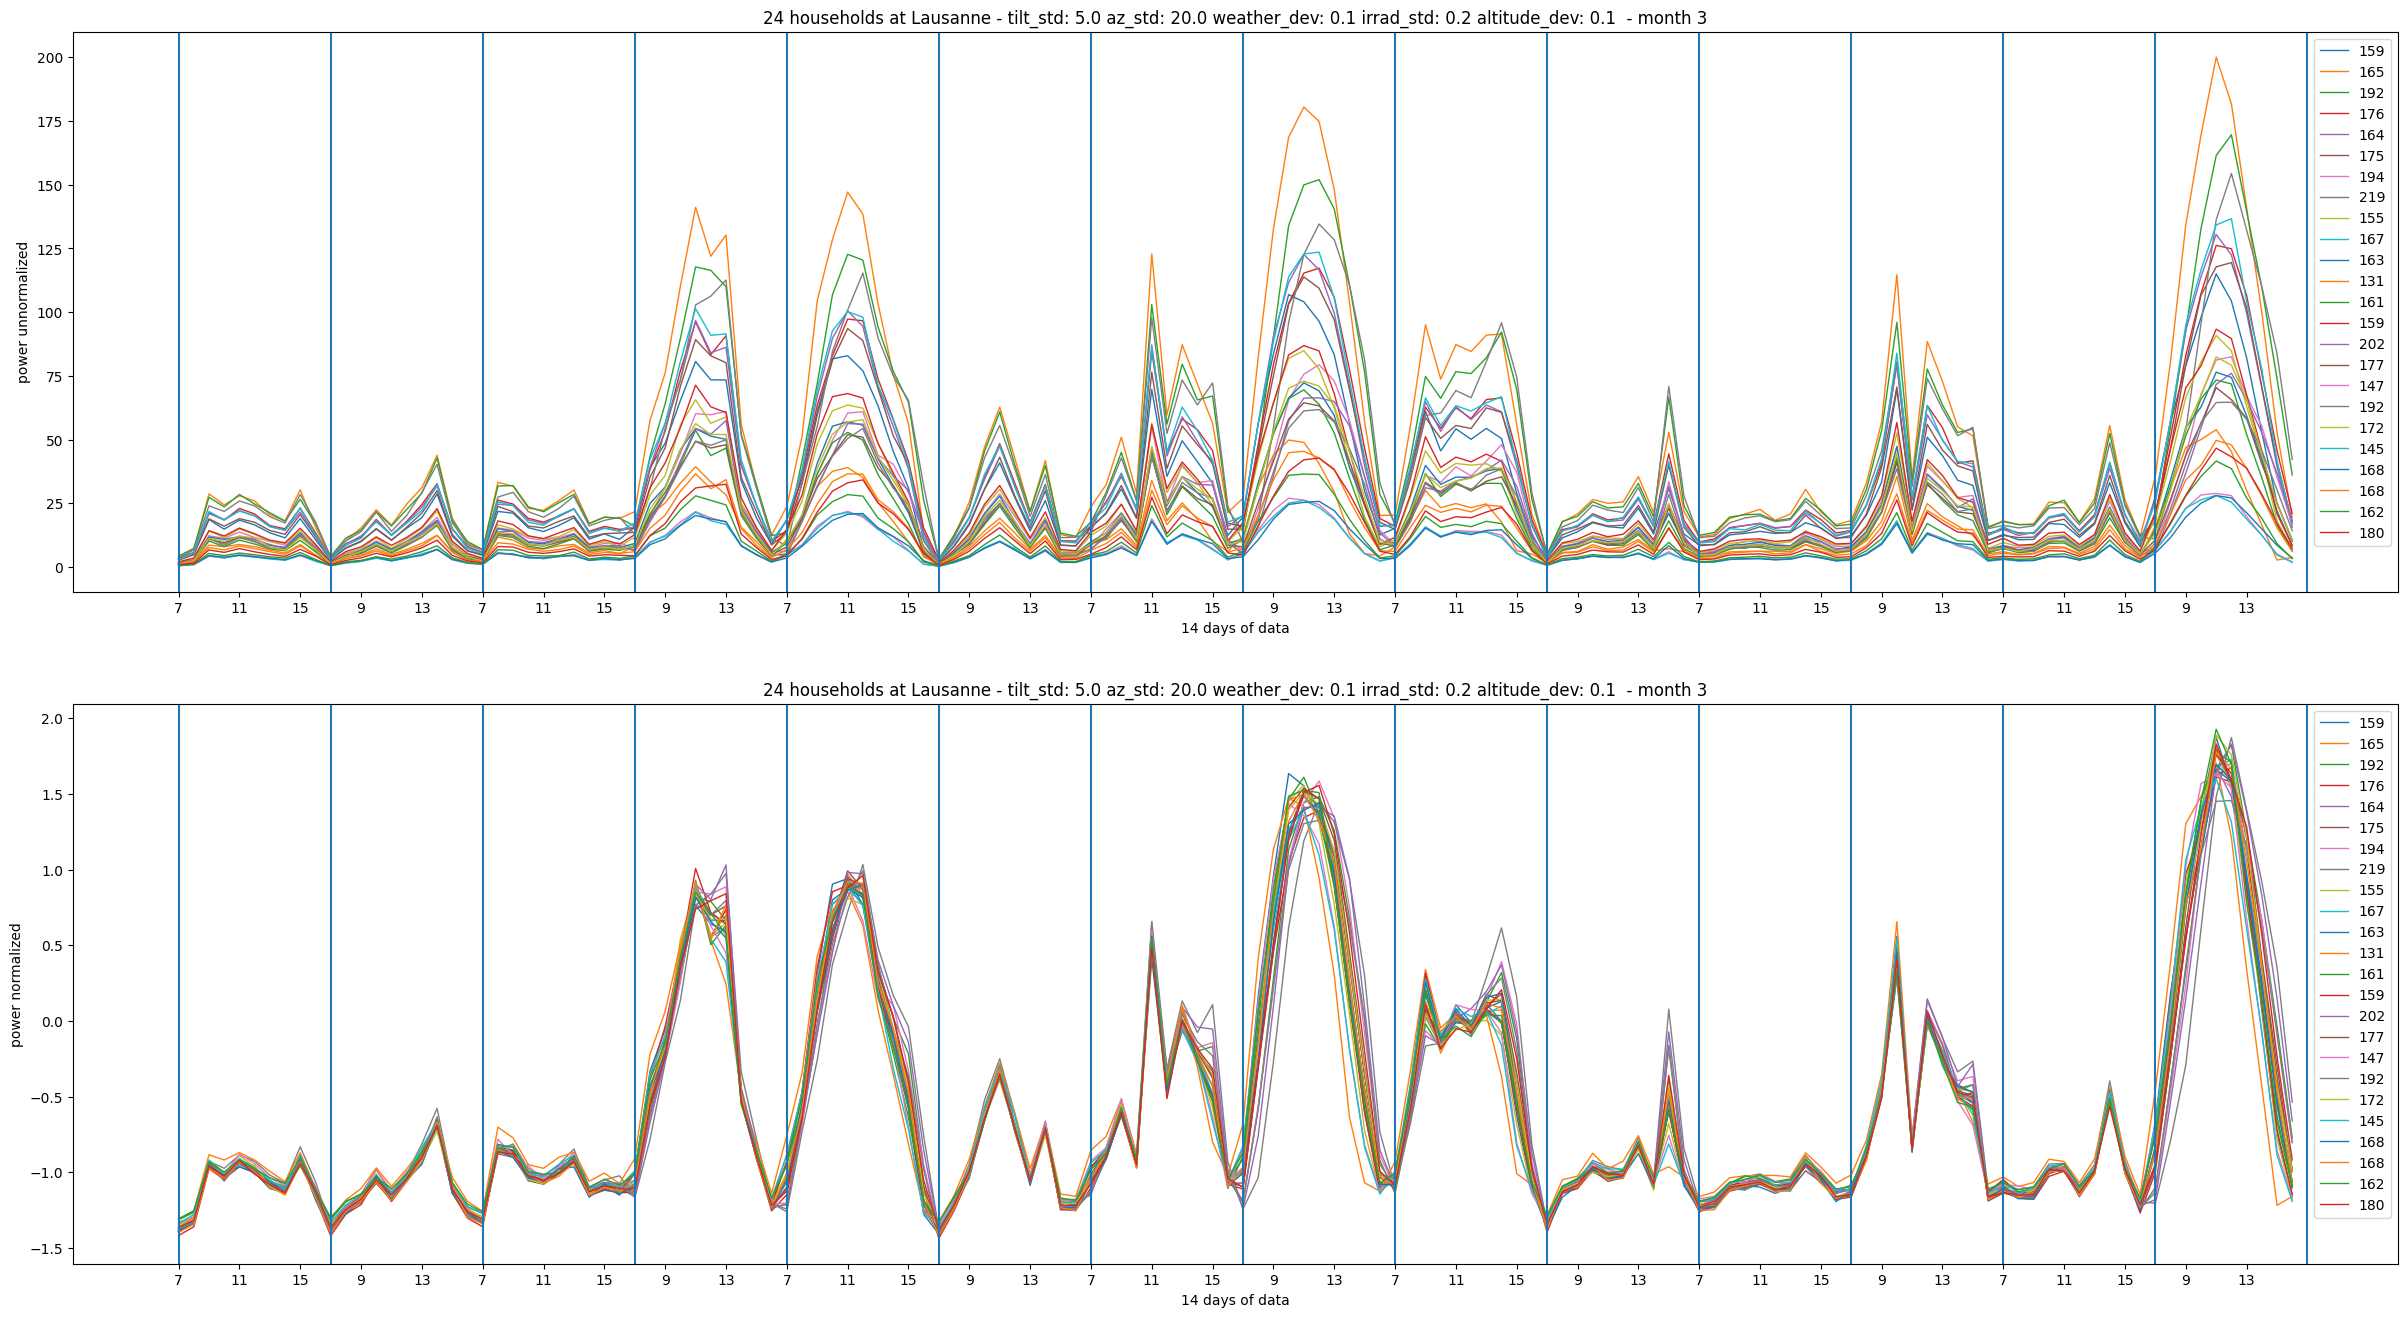

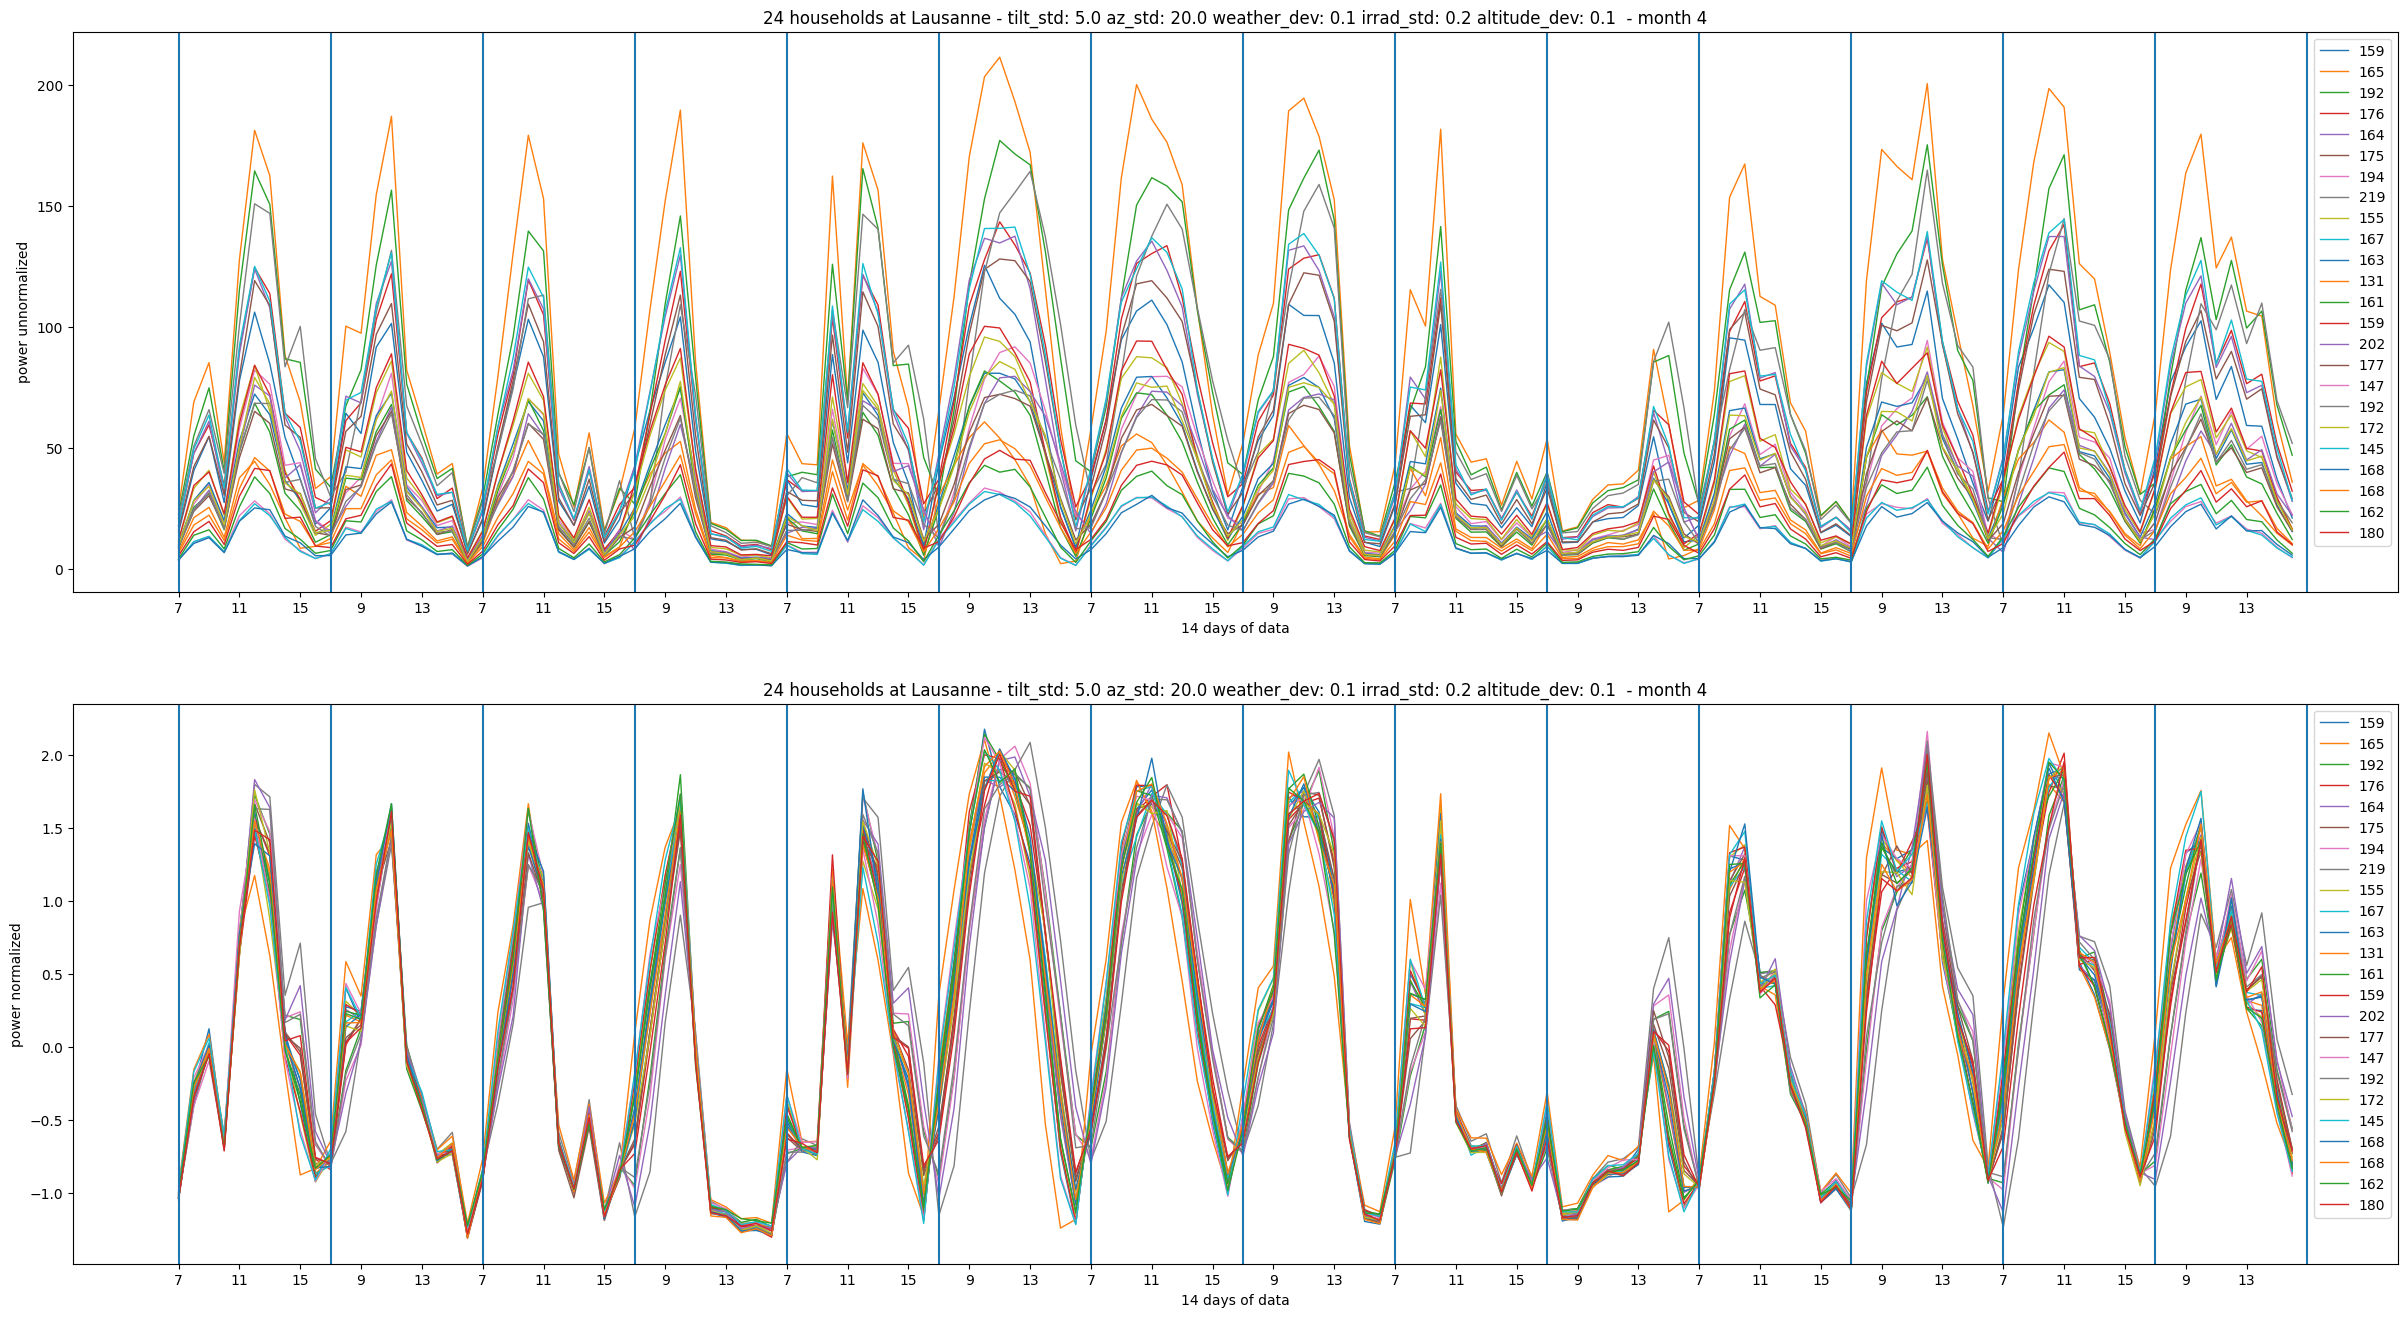

In [53]:
labels = [int(x) for x in env_dict['clients_config']['azimuth']]
colors =  [(0,1,0), (0,0,1), (1,0,1)]#list(itertools.product((0,1), (0,1), (0,1)))[1:-1]
#random.shuffle(colors)

# plot 3 days in 2018
num_days=14
for month_ind, month in enumerate(env_dict['months']):
    client_num = 0
    fig, axs = plt.subplots(2, 1, figsize = (30, 8*2))
    for mode_num in np.arange(env_dict['num_modes']):
        for i in np.arange(env_dict['num_clients_per_mode'][mode_num]):
            intensity = 0.2+(1-0.2)*i/(env_dict['num_clients_per_mode'][mode_num]-1) if env_dict['num_clients_per_mode'][mode_num]>1 else 255
            color = tuple(x * intensity for x in colors[mode_num])
            
            _, y_train, _, y_valid = env_dict['clients_data_full'][client_num]

            # plot unnormalized
            ts_unnorm = env_dict['clients_ts_2018'][client_num]
            ts_unnorm = ts_unnorm.loc[ts_unnorm['month']==month, :]
            ts_unnorm = ts_unnorm.loc[ts_unnorm['hour_day'].isin(env_dict['hours']), :]
            ts_unnorm = ts_unnorm.iloc[np.arange(num_days*len(env_dict['hours'])), :]
         
            if mode_num>-1:
                axs[0].plot(np.arange(num_days*len(env_dict['hours'])),
                            ts_unnorm.loc[:, 'p_mp'], label=labels[client_num], lw=1)

            # plot normalized
            y_mean, y_std = np.mean(y_train, axis=0), np.std(y_train, axis=0) + 1e-8
            ts_norm = (ts_unnorm.loc[:, 'p_mp'] - y_mean) / y_std
            #assert ts_norm.shape == y_train.shape
            if mode_num>-1:
                axs[1].plot(np.arange(num_days*len(env_dict['hours'])),
                            ts_norm, label=labels[client_num], lw=1)

            client_num += 1
    axs[0].set_ylabel('power unnormalized')
    axs[1].set_ylabel('power normalized')
    for ax in axs:
        ax.set_title(env_dict['info'] + ' - month ' + str(month))
        for i in np.arange(num_days+1):
            ax.axvline(x=len(env_dict['hours'])*i, ymin=0, ymax=1)
        tick_locs = np.linspace(0, num_days*len(env_dict['hours']), 
                                num=int(num_days*len(env_dict['hours'])/4), 
                                endpoint=False).astype(int)
        ax.set_xticks(tick_locs, labels=ts_unnorm.loc[:, 'hour_day'].iloc[tick_locs])
        ax.set_xlabel(str(num_days) + ' days of data')
        ax.legend()
    plt.show()

# ts_norm.loc[:, 'hour_day'], 

# Search space for GP structures

In [65]:
# -------- Define a fixed hyper-prior --------
hyper_prior_dict = {'lengthscale_raw_loc': 5,'lengthscale_raw_scale': 2.5, 
                    'noise_raw_loc': 10, 'noise_raw_scale': 5}

# set properties that are different based on the GP mean
search_spaces_big = {
                'CONSTANT':{'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                            'covar_module_str': ['NN','linear'], 'mean_module_str':['constant'],
                            'kernel_nn_layers': [(int(n),int(n)) for n in np.logspace(0, 4, num=5, base=2)]},
                'LINEAR':  {'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                            'covar_module_str': ['NN'], 'mean_module_str':['linear'],
                            'kernel_nn_layers': [(int(n), int(n)) for n in np.logspace(0, 4, num=5, base=2)]},
                'NN':      {'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                            'covar_module_str': ['NN'], 'mean_module_str':['NN'],
                            'mean_nn_layers':   [(int(n),int(n)) for n in [1, 4, 8]],
                            'kernel_nn_layers': [(int(n),int(n)) for n in np.logspace(0, 4, num=5, base=2)]}}

search_spaces_sml = {
                'LINEAR':  {'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                            'covar_module_str': ['zero'], 'mean_module_str':['linear'],
                            'kernel_nn_layers': []},
                'NN':      {'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                            'covar_module_str': ['NN'], 'mean_module_str':['NN'],
                            'mean_nn_layers':   [(4,4), (16,16)],
                            'kernel_nn_layers': [(4,4)]}}

search_spaces = search_spaces_sml #TODO: change


options_shared=copy.deepcopy(search_spaces['NN']).update({
        'nonlinearity_output': None, 'nonlinearity_hidden': torch.tanh,
        'feature_dim':feature_dim, 
        # Configuration for GP-Prior learning
        'lr': 1e-2,           # learning rate for Adam optimizer'
        'lr_decay': 0.90,     # 'multiplicative learning rate decay factor applied after every 1000 steps'
        'task_batch_size': 5, # 'batch size for meta training, i.e. number of tasks for computing grads'
        'normalize_data': normalize_data,
        # Configuration for SVGD
        'num_iter_fit': 5000,
        'max_iter_fit': 7000,
        'early_stopping': True,
        'num_particles': [1],
        'bandwidth': 1,
        'n_threads': 8,
        'hyper_prior_dict': {},
        # loss parameters
        'prior_factor': 0.1*np.logspace(-1, 0.25, 4) #np.logspace(np.log10(1/num_clients/beta+1e-6), np.log10(1+1/num_clients/beta-1e-6), 4)
})


In [58]:
clients_subset = np.sort(random_state.choice(np.arange(num_clients), 
                                     size=5, replace=False))
if 'baseline' in methods or 'benchmark' in methods:
    msg = '[INFO] baseline and benchmark only use the following subset of clients: '
    for n in clients_subset:
        msg += str(n) + ', '
    del n
    print(msg)
#logger.info(msg)
clients_subset = [1, 3, 13, 17, 19]

[INFO] baseline and benchmark only use the following subset of clients: 1, 3, 13, 17, 19, 


# Benchmark
* GP with structure search on 2Y data
* Each household searches and trains individually
* Results are averaged to evaluate the method

In [66]:
if 'benchmark' in methods:
    # Linear regression without GP
    valid_rmses_linreg = np.zeros(num_clients)
    for client_num in np.arange(num_clients):
        print('\nClient {:2.0f}'.format(client_num))
        _, valid_rmses_linreg[client_num] = best_lin_reg(clients_data=env_dict['clients_data_2y'], 
                    client_num=client_num, logger=None, normalize_data=normalize_data) 
    print('\n---------- LINEAR AND RIDGE REGRESSION WITHOUT GP ----------')
    print('mean validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses_linreg),
                                                            1.96*np.std(valid_rmses_linreg)))

    # GP with search over structure
    for gp_mean, search_space in search_spaces.items():
        valid_rmses= np.zeros(len(clients_subset))
        valid_clbrs= np.zeros(len(clients_subset))
        options_personal = copy.deepcopy(options_shared)
        options_personal.update(search_space)
        print('\n---------- ' + gp_mean + ' MEAN GP ----------')
        for client_num in clients_subset:
            print('\nClient {:2.0f}'.format(client_num))
            
            _, res = find_best_model(clients_data=env_dict['clients_data_2y'], 
                                     client_num=client_num, # only evaluate on this client
                                     random_seed=random_seed, 
                                     logger=None, mode='personal', verbose=True, options=options_personal)

            valid_rmses[client_num], valid_clbrs[client_num] = res['valid_rmse'], res['valid_calibr']
        # average over all clients
        print('validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses),
                                                           1.96*np.std(valid_rmses)))
        print('validation calibration: {:.4f} +/- {:.4f}'.format(np.mean(valid_clbrs),
                                                           1.96*np.std(valid_clbrs)))
                                                                


Client  0

Non-regularized linear model errors on the reduced dataset:
Train R2 score = 0.9740, Valid R2 score = 0.9631
Train RMSE = 5.6717, Valid RMSE = 6.6708

Best Ridge linear model (alpha = 9.43):
Train R2 score = 0.9735, Valid R2 score = 0.9637
Train RMSE = 5.7254, Valid RMSE = 6.6207

Client  1

Non-regularized linear model errors on the reduced dataset:
Train R2 score = 0.9896, Valid R2 score = 0.9859
Train RMSE = 6.4141, Valid RMSE = 7.5834

Best Ridge linear model (alpha = 1.60):
Train R2 score = 0.9896, Valid R2 score = 0.9859
Train RMSE = 6.4192, Valid RMSE = 7.5785

Client  2

Non-regularized linear model errors on the reduced dataset:
Train R2 score = 0.9933, Valid R2 score = 0.9896
Train RMSE = 4.2868, Valid RMSE = 5.2598

Best Ridge linear model (alpha = 9.43):
Train R2 score = 0.9929, Valid R2 score = 0.9901
Train RMSE = 4.4040, Valid RMSE = 5.1432

Client  3

Non-regularized linear model errors on the reduced dataset:
Train R2 score = 0.9970, Valid R2 score = 0.9962


AttributeError: 'NoneType' object has no attribute 'update'

# Baseline
* GP with structure search on reduced data

In [ ]:
def get_mean_name(gp):
    if isinstance(gp, GPRegressionLearned):
        learned_mean = gp.model.learned_mean
        mean_module = gp.model.mean_module
    elif isinstance(gp, GPRegressionMetaLearned):
        learned_mean = gp.nn_mean_fn
        mean_module = gp.mean_module
    else:
        raise NotImplementedError
        
    if not learned_mean is None:
        return 'NN'
    if isinstance(mean_module, gpytorch.means.LinearMean):
        return 'LINEAR'
    if isinstance(mean_module, gpytorch.means.ConstantMean):
        return 'CONSTANT'
    raise NotImplementedError


if 'baseline' in methods:
    # set up logger for personal models on reduced data. all clients logged to the same file
    # NOTE: to parallize, must set up multiple loggers
    logging.basicConfig(filename=filename_log+'_personal_red', 
                        format='%(asctime)s %(message)s', filemode='w')
    logger_personal_red=logging.getLogger()
    logger_personal_red.setLevel(logging.DEBUG)

    # record learned params
    se_length_scale_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    se_output_scale_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    nn_length_scale_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    nn_output_scale_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    ln_variance_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    se_noise_std_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    nn_noise_std_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    ln_noise_std_raws = {'CONSTANT':[], 'LINEAR':[], 'NN':[]} 
    
    
    # find best model for each mean
    for name, search_space in search_spaces.items():
        valid_rmses_baseline = np.zeros(len(clients_subset))
        valid_clbrs_baseline = np.zeros(len(clients_subset))

        for ind, client_num in enumerate(clients_subset):
            print('\nClient {:2.0f}'.format(client_num))
            gp, res = find_best_model(clients_data=env_dict['clients_data_red'], 
                                            client_num=client_num, normalize_data=normalize_data, mode='personal', 
                                            search_space=search_space, logger=logger_personal_red, random_seed=random_seed,
                                            feature_dim=feature_dim, lr=1e-3, lr_decay = 0.9, weight_decay=0.0, n_iter_fit =5000, verbose=True)
            valid_rmses_baseline[ind], valid_clbrs_baseline[ind] = res['valid_rmse'], res['valid_calibr']
            # record parameters of the best GP
            if isinstance(gp.model.covar_module, gpytorch.kernels.ScaleKernel): # SE or NN kernel
                if gp.model.learned_kernel is None: # SE kernel
                    se_length_scale_raws[get_mean_name(gp)].append(gp.model.covar_module.base_kernel.raw_lengthscale.detach().numpy())
                    se_output_scale_raws[get_mean_name(gp)].append(gp.model.covar_module.raw_outputscale.detach().numpy())
                    se_noise_std_raws[get_mean_name(gp)].append(gp.model.likelihood.raw_noise.detach().numpy())
                else: # NN kernel 
                    nn_length_scale_raws[get_mean_name(gp)].append(gp.model.covar_module.base_kernel.raw_lengthscale.detach().numpy())
                    nn_output_scale_raws[get_mean_name(gp)].append(gp.model.covar_module.raw_outputscale.detach().numpy())
                    nn_noise_std_raws[get_mean_name(gp)].append(gp.model.likelihood.raw_noise.detach().numpy())
            if isinstance(gp.model.covar_module, gpytorch.kernels.LinearKernel): 
                ln_variance_raws[get_mean_name(gp)].append(gp.model.covar_module.raw_variance.detach().numpy())
                ln_noise_std_raws[get_mean_name(gp)].append(gp.model.likelihood.raw_noise.detach().numpy())
        print('\n---------- ' + name +' MEAN GP ----------')
        print('mean validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses_baseline),
                                                                1.96*np.std(valid_rmses_baseline)))
        print('mean validation calibration: {:.4f} +/- {:.4f}'.format(np.mean(valid_clbrs_baseline),
                                                                1.96*np.std(valid_clbrs_baseline)))

    logger_personal_red.info(str("se_length_scale_raws: ", se_length_scale_raws))
    logger_personal_red.info(str("se_output_scale_raws: ", se_output_scale_raws))
    logger_personal_red.info(str("nn_length_scale_raws: ", nn_length_scale_raws))
    logger_personal_red.info(str("nn_output_scale_raws: ", nn_output_scale_raws))
    logger_personal_red.info(str("ln_variance_raws: ", ln_variance_raws))
    logger_personal_red.info(str("se_noise_std_raws: ", se_noise_std_raws))
    logger_personal_red.info(str("nn_noise_std_raws: ", nn_noise_std_raws))
    logger_personal_red.info(str("ln_noise_std_raws: ", ln_noise_std_raws))
    

## Baseline/Benchmark Regularized
To see if the improvement only comes from regularization or also from num particles

In [ ]:
from utils.search_models import handle_search_space
from utils.assistive_functions import print_gp_prior_params
from meta_learn import GPRegressionMetaLearnedSVGD

def softplus_integer(a):
    return torch.nn.Softplus()(torch.Tensor([a])).detach().numpy()[0]

if 'baseline_regul' in methods or 'benchmark_regul' in methods:
    methods_reg = list(set(methods) & set(['baseline_regul', 'benchmark_regul']))
    for method_reg in methods_reg:
        # select data
        if method_reg=='baseline_regul':
            data = env_dict['clients_data_red']
            print('\nREDUCED DATASET \n')
        else:
            data = env_dict['clients_data_2y']
            print('\n2 YEARS DATASET \n')

        # setup logger
        logging.basicConfig(filename=filename_log+'_'+method_reg, 
                            format='%(asctime)s %(message)s', filemode='w')
        logger=logging.getLogger(method_reg)
        logger.setLevel(logging.DEBUG)

        # all modelling options
        verbose=True
        options=copy.deepcopy(search_spaces['NN'])
        options.update({
                #'mean_nn_layers': [(4,4)], 'kernel_nn_layers':[(4,4)], # NOTE: over-ride search space
                'feature_dim':feature_dim,
                'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                # Configuration for GP-Prior learning
                'lr': 1e-2,           # learning rate for Adam optimizer'
                'lr_decay': 0.90,     # 'multiplicative learning rate decay factor applied after every 1000 steps'
                'task_batch_size': 5, # 'batch size for meta training, i.e. number of tasks for computing grads'
                'normalize_data': True,
                # Configuration for SVGD
                'num_iter_fit': 3000, 'max_iter_fit': 5000,
                'early_stopping': True,
                'num_particles': [1], 'bandwidth': [1],
                'n_threads': 8,
                'hyper_prior_dict': hyper_prior_dict,
                # loss parameters
                'prior_factor': np.logspace(-3, 0, num=4) 
        })

        # ----- TRAIN MODELS -----
        names = ['client ' + str(i) for i in clients_subset]
        best_setups, best_gps = dict.fromkeys(names, 0), dict.fromkeys(names, 0)
        for client_num in clients_subset: # use our method with only one client to get regularized individual models
            print('\n CLIENT ' + str(client_num))
            # tune
            best_gps['client ' + str(client_num)], best_setups['client ' + str(client_num)] = find_best_model(clients_data=[data[client_num]],  
                                                random_seed=random_seed, logger=logger, mode='ours', client_num=None, verbose=True, options=options)
                                                
            # print results
            print(best_setups['client ' + str(client_num)])
            print_gp_prior_params(best_gps['client ' + str(client_num)])
        file = open(filename_save+'_'+method_reg, 'wb')
        pickle.dump({'best_setups': best_setups, 'best_gps':best_gps}, file)
        file.close()



# FedAvg

In [ ]:
if 'fedavg' in methods:
    logging.basicConfig(filename=filename_log+'_fedavg', 
                        format='%(asctime)s %(message)s', filemode='w')
    logger_fedavg=logging.getLogger()
    logger_fedavg.setLevel(logging.DEBUG)
    
    names = search_space.keys()
    best_gps, res_fedavg = dict.fromkeys(names, 0), dict.fromkeys(names, 0)

    # find best model for each mean
    for name, search_space in search_spaces.items():
        best_gps[name], res_fedavg[name] = find_best_model(clients_data=env_dict['clients_data_red'],
                                normalize_data=normalize_data, random_seed=random_seed, mode='fedavg', 
                                search_space=search_space, logger=logger_fedavg, lr=1e-2, feature_dim=feature_dim,
                                lr_decay = 0.9, weight_decay=0.0, n_iter_fit =5000, verbose=True)
      
        # print parameters
        print_gp_prior_params(best_gps[name])
        

# ours

In [ ]:
# big search space over models. high regularization
run_cell=True

if 'ours' in methods and run_cell:
    data_size = 'RED' # NOTE: CHANGE
    if data_size=='2Y':
        data = env_dict['clients_data_2y']
    elif data_size=='RED':
        data = env_dict['clients_data_red']
    elif data_size=='FULL':
        data = env_dict['clients_data_full']
    else:
        raise NotImplementedError

    # -------- Define a fixed hyper-prior --------
    hyper_prior_dicts = []
    for l in [-3, 5, 10]:
        for n in [-3, 5, 10]:
            hyper_prior_dicts.append({'lengthscale_raw_loc': l,'lengthscale_raw_scale': np.abs(l)/2, 
                        'noise_raw_loc': n, 'noise_raw_scale': np.abs(n)/2})

    # ----- SET UP LOGGER -----
    exp_name = 'PV_Lausanne_ours'
    filename_log  = os.path.join(PROJECT_DIR , 'experiments', 'saved_results', exp_name +'_red.log')
    filename_save = os.path.join(PROJECT_DIR , 'experiments', 'saved_results', exp_name + "_models")
    now = datetime.now().strftime("%Y_%m_%d,%H:%M:%S")
    logging.basicConfig(filename=filename_log, format='%(asctime)s %(message)s', filemode='w')
    logger=logging.getLogger(exp_name+'_red')
    logger.setLevel(logging.DEBUG)
    verbose=True
    save_models = False


    # all modelling options
    options=copy.deepcopy(search_spaces['NN'])
    options.update({
            'mean_nn_layers':   [(100,)], #(16, 16), 
            'kernel_nn_layers': [(4,4)],
            'nonlinearity_output': None, 'nonlinearity_hidden': [torch.tanh, torch.relu],
            'feature_dim':2, 
            # Configuration for GP-Prior learning
            'lr': 1e-2,           # learning rate for Adam optimizer'
            'lr_decay': 0.90,     # 'multiplicative learning rate decay factor applied after every 1000 steps'
            'task_batch_size': 5, # 'batch size for meta training, i.e. number of tasks for computing grads'
            'normalize_data': True,
            # Configuration for SVGD
            'num_iter_fit': 3000,
            'max_iter_fit': 5000,
            'early_stopping': True,
            'num_particles': [1],
            'bandwidth': 1,
            'n_threads': 8,
            'hyper_prior_dict': hyper_prior_dicts,
            # loss parameters
            'prior_factor': 0.1*np.logspace(-1, 0.25, 4) #np.logspace(np.log10(1/num_clients/beta+1e-6), np.log10(1+1/num_clients/beta-1e-6), 4)
    })

    # tune
    best_gp, best_setup = find_best_model(clients_data=data, random_seed=random_seed, 
                                          logger=logger, mode='ours', client_num=None, verbose=True, options=options)
    # print results
    print(best_setup)
    print_gp_prior_params(best_gp)



## Detailed search
based on the big search, we selected only 5 models.

### smaller search 1: 
for these 4 models with 'bandwidth': [0.05, 0.1, 0.2, 1, 10], num_particles:[1,3], 'prior_factor': np.logspace(-5, -2, num=4, base=2) 
observations: robust to BW, good PF between 1/16, 1/8

### smaller search 2:
for these 4 models with 'bandwidth': [0.1, 1], 'num_particles': [1, 3, 9], 'prior_factor': np.linspace(0.0375, 0.1, num=6) 
* 'mean_nn_layers':(8,8), 'kernel_nn_layers':(1,1) => num hyper-params = 216
    * best = 20.33 +/- 5.75 with 1 particle
    * for all num particles: 20.33, 20.50, 20.55
* 'mean_nn_layers':(4,4), 'kernel_nn_layers':(2,2) => num hyper-params = 124
    * best = 20.39 +/- 5.43 with 3 particles
    * 20.58, 20.39, 20.45
* 'mean_nn_layers':(4,4), 'kernel_nn_layers':(4,4) => num hyper-params = 170
    * best = 20.27 +/- 5.22 with 3 particles
    * 20.42, 20.27, 20.48
* 'mean_nn_layers':(4,4), 'kernel_nn_layers':(8,8) => num hyper-params = 286
    * best = 20.31 +/- 5.68 with 9 particles
    * 20.39, 20.50, 20.31


Conclusions: all 4 models were similar, num particles doesn't have a significant effect

In [ ]:
run_cell=False

if 'ours' in methods and run_cell:
    client_num = None # evaluate on all clients
    clients_data = env_dict['clients_data_red']
    # subset of models selected from the big search
    model_infos = [{'mean_nn_layers':(8,8), 'kernel_nn_layers':(1,1)},
                   {'mean_nn_layers':(4,4), 'kernel_nn_layers':(2,2)},
                   {'mean_nn_layers':(4,4), 'kernel_nn_layers':(4,4)},
                   {'mean_nn_layers':(4,4), 'kernel_nn_layers':(8,8)}
                   ]
    # all modelling options
    options_shared={'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
            'covar_module_str': ['NN'], 'mean_module_str':['NN'],'feature_dim':feature_dim,
            # Configuration for GP-Prior learning
            'lr': 1e-2,           # learning rate for Adam optimizer'
            'lr_decay': 0.90,     # 'multiplicative learning rate decay factor applied after every 1000 steps'
            'task_batch_size': 5, # 'batch size for meta training, i.e. number of tasks for computing grads'
            'normalize_data': True,
            # Configuration for SVGD
            'num_iter_fit': 5000,
            'max_iter_fit': 7000,
            'early_stopping': True,
            'num_particles': [1, 3, 9],
            'bandwidth': [0.1, 1],
            'n_threads': 8,
            'hyper_prior_dict': hyper_prior_dict,
            # loss parameters
            'prior_factor': np.linspace(0.0375, 0.1, num=6) 
    }

    for model_info in model_infos:
        options = copy.deepcopy(options_shared)
        options.update(model_info)
        # tune
        best_gp, best_setup = find_best_model(clients_data=env_dict['clients_data_red'], random_seed=random_seed, 
                                          logger=logger, mode='ours', client_num=None, verbose=True, options=options)
        # print results
        print(best_setup)
        print_gp_prior_params(best_gp)



# Evaluate

Train on small data, test on the whole 2019

In [ ]:
load_saved_models = False
if not load_saved_models:
    # best_FedAvg
    search_space={'optimize_noise':True, 'noise_std':None, 
                  'covar_module_str': ['NN'], 'mean_module_str':['NN'],
                  'kernel_nn_layers':[(1,1)], 'mean_nn_layers':[(1,1)]}

    best_gp_fedavg, best_res_fedavg = find_best_model(clients_data=env_dict['clients_data_red'],
                                                      random_seed=random_seed, mode='fedavg', logger=None, verbose=True,
                                                      options={'normalize_data':normalize_data,
                                                                'lr':1e-2, 'feature_dim':feature_dim,
                                                                'lr_decay':0.9, 'weight_decay':0.0, 'n_iter_fit':5000,
                                                                #'nonlinearity_output': None, 'nonlinearity_hidden':torch.tanh,
                                                                'search_space':search_space})

    best_gp_ours, best_res_ours = find_best_model(clients_data=env_dict['clients_data_red'], random_seed=random_seed, 
                                  logger=None, mode='ours', client_num=None, verbose=True, 
                                  options={'mean_nn_layers':[(4,4)], 'kernel_nn_layers':[(8,8)],
                                          'optimize_noise':True, 'noise_std':None,   # learn GP posterior noise
                                          'covar_module_str': ['NN'], 'mean_module_str':['NN'],'feature_dim':feature_dim,
                                          'lr': 1e-2, 'lr_decay': 0.90, 'task_batch_size': 5, 'normalize_data': True,
                                          'num_iter_fit': 7000, 'max_iter_fit': 9000, 'early_stopping': True,
                                          'num_particles': 3, 'bandwidth': 0.1, 'n_threads': 8, 'hyper_prior_dict': hyper_prior_dict,
                                          'prior_factor': 0.0625, 'nonlinearity_output': None, 'nonlinearity_hidden':torch.tanh})
    file = open(filename_save+"_best_models", 'wb')
    pickle.dump({'best_gp_fedavg': best_gp_fedavg, 
                 'best_gp_ours':serialize_model(best_gp_ours, normalize_data=normalize_data, random_seed=random_seed)},
                file)
    load_saved_models = True
else:
    file = open(filename_save+"_best_models", 'rb')
    res = pickle.load(file)
    best_gp_ours = res['best_gp_ours']
    best_gp_ours = TrainedSVGD(best_gp_ours) #TODO
    best_gp_fedavg = res['best_gp_fedavg']
file.close()




 ------ fedavg evaluated on all clients------
[INFO] training NN mean of size ( 1 x  1), NN kernel of size ( 1 x  1) with optimized noise
[2022-11-14 04:35:46,359 -INFO]  Iter 1/5000 - Loss: 7.033767 - Time 0.01 sec - Valid-LL: -5.088 - Valid-RMSE: 37.782 - Calib-Err 0.099
[2022-11-14 04:35:58,278 -INFO]  Iter 1000/5000 - Loss: 3.544366 - Time 11.92 sec - Valid-LL: -4.635 - Valid-RMSE: 23.267 - Calib-Err 0.091
[2022-11-14 04:36:10,509 -INFO]  Iter 2000/5000 - Loss: 3.260217 - Time 12.05 sec - Valid-LL: -4.648 - Valid-RMSE: 23.374 - Calib-Err 0.086
[2022-11-14 04:36:22,657 -INFO]  Iter 3000/5000 - Loss: 3.198920 - Time 12.04 sec - Valid-LL: -4.644 - Valid-RMSE: 23.485 - Calib-Err 0.088
[2022-11-14 04:36:34,869 -INFO]  Iter 4000/5000 - Loss: 3.186944 - Time 12.10 sec - Valid-LL: -4.625 - Valid-RMSE: 23.633 - Calib-Err 0.086
[2022-11-14 04:36:47,123 -INFO]  Iter 5000/5000 - Loss: 3.199891 - Time 12.14 sec - Valid-LL: -4.653 - Valid-RMSE: 23.744 - Calib-Err 0.088
Train RMSE= 16.70 +/- 7

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
print(best_gp_ours.num_particles)

3


In [ ]:
run_cell = False
only_mean = False # predict only by GP mean or mean + kernel
if run_cell: 
    import scipy.stats as stats
    # plot predictions by mean and residuals
    fig, axs = plt.subplots(2*len(clients_subset), 1, figsize=(48, 8*2*len(clients_subset)))
    fig_box, axs_box = plt.subplots(len(clients_subset), 2, figsize=(8*2, 8*len(clients_subset)))
    for ind, client_num in enumerate(clients_subset):
        x_train, y_train, _, _ = env_dict['clients_data_red'][client_num]
        _, _, x_valid, y_valid = env_dict['clients_data_full'][client_num]
        if only_mean:
            pred_ours_train = best_gp_ours.predict_only_mean(x_train, y_train, x_train).reshape(y_train.shape)
            pred_ours_valid = best_gp_ours.predict_only_mean(x_train, y_train, x_valid).reshape(y_valid.shape)
            pred_fedavg_train = best_gp_fedavg.predict_only_mean(x_train, y_train, x_train).reshape(y_train.shape)
            pred_fedavg_valid = best_gp_fedavg.predict_only_mean(x_train, y_train, x_valid).reshape(y_valid.shape)
        else:
            pred_ours_train = best_gp_ours.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
            pred_ours_valid = best_gp_ours.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)
            pred_fedavg_train = best_gp_fedavg.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
            pred_fedavg_valid = best_gp_fedavg.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)
        t = np.arange(len(y_valid))
        t_train = np.arange(len(y_train))

        # predictions on validation data
        ax = axs[2*ind]
        ax.plot(t, y_valid, 'r-o', label='true', markersize=2)
        ax.plot(t, pred_ours_valid, 'c-o', label='prediction ours', markersize=2)
        ax.plot(t, pred_fedavg_valid, 'b-o', label='prediction FedAvg', markersize=2)
        ax.set_xlabel('sample number')
        ax.set_ylabel('power')
        if only_mean:
            ax.set_title('predictions only by GP mean for client {:2.0f} (azimuth = {:2.2f}) - validation'.format(client_num,env_dict['clients_config']['azimuth'][client_num]))
        else:
            ax.set_title('predictions for client {:2.0f} (azimuth = {:2.2f}) - validation'.format(client_num,env_dict['clients_config']['azimuth'][client_num]))
        ax = axs[2*ind+1]
        ax.stem(t, y_valid-pred_ours_valid, 'c', label='residuals ours')
        ax.stem(t, y_valid-pred_fedavg_valid, 'b', label='residuals FedAvg')
        ax.set_xlabel('sample number')
        ax.set_ylabel('true-predicted power')
        if only_mean:
            ax.set_title('prediction residuals of GP mean for client {:2.0f} (azimuth = {:2.2f}) - validation'.format(client_num,env_dict['clients_config']['azimuth'][client_num]))
        else:
            ax.set_title('prediction residuals for client {:2.0f} (azimuth = {:2.2f}) - validation'.format(client_num,env_dict['clients_config']['azimuth'][client_num]))

        # box plots
        ax = axs_box[ind, 0]
        e_ours_train = np.abs(y_train-pred_ours_train).flatten()
        e_ours_valid = np.abs(y_valid-pred_ours_valid).flatten() 
        e_fedavg_valid = np.abs(y_valid-pred_fedavg_valid).flatten()
        e_fedavg_train = np.abs(y_train-pred_fedavg_train).flatten()
        ax.boxplot([e_ours_train, e_ours_valid, e_fedavg_valid, e_fedavg_train])
        ax.set_xticks([1, 2, 3, 4], ['ours train', 'ours valid', 'FedAvg valid', 'FedAvg train'])
        ax.set_title('absolute error for client {:2.0f}'.format(client_num))
        ax.set_ylabel('|true-pred|')

        # fit Gaussian to abs error for each house
        ax = axs_box[ind, 1]
        mu_fedavg, std_fedavg = np.mean(e_fedavg_valid), np.std(e_fedavg_valid)
        mu_ours, std_ours = np.mean(e_ours_valid), np.std(e_ours_valid)
        x_min = min(mu_fedavg-3*std_fedavg, mu_ours-3*std_ours)
        x_max = min(mu_fedavg+3*std_fedavg, mu_ours+3*std_ours)
        x = np.linspace(x_min, x_max, 100)
        ax.plot(x, stats.norm.pdf(x, mu_ours, std_ours), c='c', label='ours')
        ax.plot(x, stats.norm.pdf(x, mu_fedavg, std_fedavg), c='b', label='FedAvg')
        

    for ax in axs.flatten():
        ax.legend()
    for ax in axs_box.flatten():
        ax.legend()


In [ ]:
residuals_train = {'FedAvg':[None]*num_clients, 'ours':[None]*num_clients}
residuals_valid = {'FedAvg':[None]*num_clients, 'ours':[None]*num_clients}
RMSE_train = {'FedAvg':np.zeros(num_clients), 'ours':np.zeros(num_clients)}
RMSE_valid = {'FedAvg':np.zeros(num_clients), 'ours':np.zeros(num_clients)}
for client_num in np.arange(num_clients):
    x_train, y_train, _, _ = env_dict['clients_data_red'][client_num]
    _, _, x_valid, y_valid = env_dict['clients_data_full'][client_num]
    
    pred_ours_train = best_gp_ours.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
    pred_ours_valid = best_gp_ours.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)
    pred_fedavg_train = best_gp_fedavg.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
    pred_fedavg_valid = best_gp_fedavg.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)

    residuals_train['ours'][client_num] = np.abs(y_train-pred_ours_train).flatten()
    residuals_valid['ours'][client_num] = np.abs(y_valid-pred_ours_valid).flatten()
    residuals_train['FedAvg'][client_num] = np.abs(y_train-pred_fedavg_train).flatten()
    residuals_valid['FedAvg'][client_num] = np.abs(y_valid-pred_fedavg_valid).flatten()
    
    RMSE_train['ours'][client_num] = np.sqrt(np.mean(residuals_train['ours'][client_num]**2))
    RMSE_valid['ours'][client_num] = np.sqrt(np.mean(residuals_valid['ours'][client_num]**2))
    RMSE_train['FedAvg'][client_num] = np.sqrt(np.mean(residuals_train['FedAvg'][client_num]**2))
    RMSE_valid['FedAvg'][client_num] = np.sqrt(np.mean(residuals_valid['FedAvg'][client_num]**2))


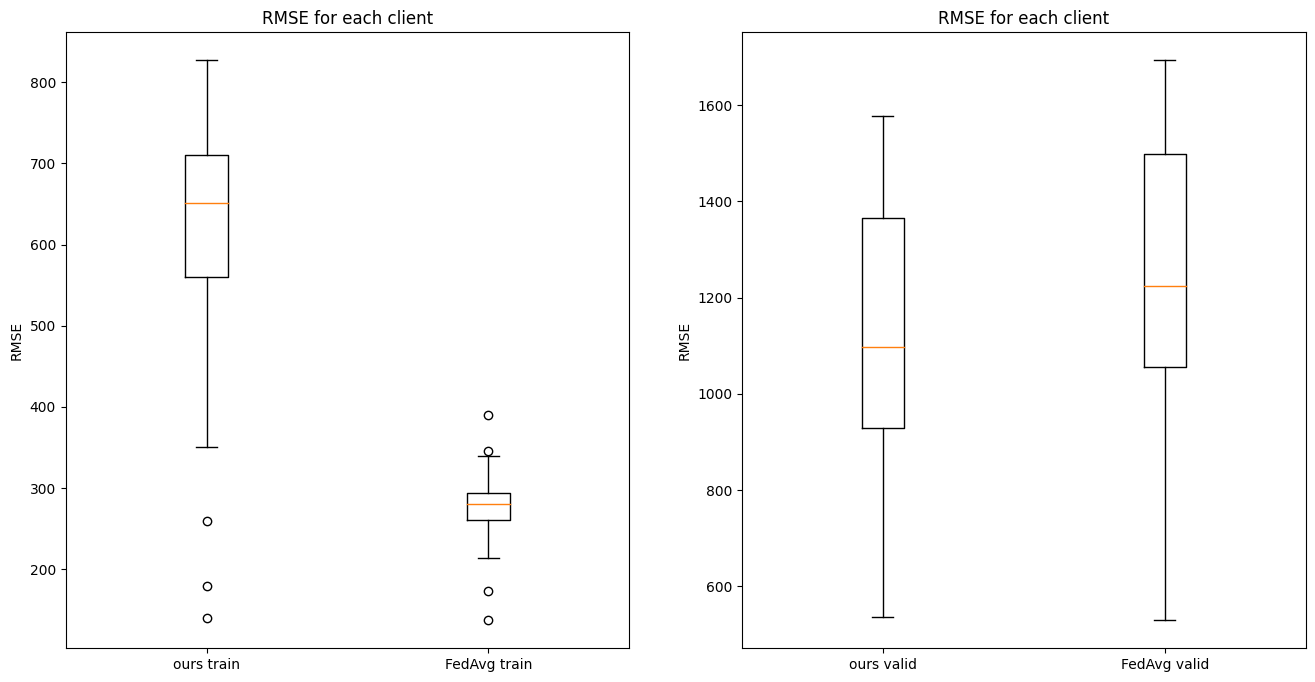

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].boxplot([RMSE_train['ours'], RMSE_train['FedAvg']])
axs[1].boxplot([RMSE_valid['ours'], RMSE_valid['FedAvg']])
axs[0].set_xticks([1, 2], ['ours train', 'FedAvg train'])
axs[1].set_xticks([1, 2], ['ours valid', 'FedAvg valid'])
for ax in axs:
        ax.set_title('RMSE for each client')
        ax.set_ylabel('RMSE')

In [ ]:
pred_ours_train = best_gp_ours.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
print(pred_ours_train)
print(y_train)
print(residuals_train['ours'][client_num])
print(residuals_train['ours'][client_num]**2)

[[-1363.7291]
 [-1286.1239]
 [-1391.472 ]
 [-1388.7538]
 [-1292.3951]
 [-1364.4777]
 [-1278.1603]
 [-1359.8733]
 [-1286.5143]
 [-1296.2316]
 [-1308.8247]
 [-1289.6095]
 [-1336.0233]
 [-1398.3486]
 [-1337.5575]
 [-1269.499 ]
 [-1264.1737]
 [-1312.8121]
 [-1335.2919]
 [-1358.8092]
 [-1268.6237]
 [-1377.1403]
 [-1344.1798]
 [-1335.1981]
 [-1363.9559]
 [-1316.7296]
 [-1284.9943]
 [-1397.5758]
 [-1352.8241]
 [-1302.3564]
 [-1400.5363]
 [-1365.2802]
 [-1271.5293]
 [-1384.5219]
 [-1398.1367]
 [-1400.4547]
 [-1287.5563]
 [-1398.0328]
 [-1391.1385]
 [-1386.475 ]]
[[-1307.32670363]
 [-2145.61919871]
 [ -508.50285301]
 [ -506.0852581 ]
 [-2114.76727633]
 [ -901.33127993]
 [-2460.14213671]
 [-1044.35103977]
 [-2144.84594453]
 [-2015.10055184]
 [-1807.84966714]
 [-2448.26748836]
 [-1394.24190322]
 [ -462.1155891 ]
 [-1492.28769868]
 [-2608.07471136]
 [-2399.71273549]
 [-1751.95958355]
 [-1317.58994395]
 [ -903.03432866]
 [-2297.93686761]
 [ -702.13386302]
 [-1116.04753084]
 [-1413.40404396]
 [-1231

In [ ]:
import scipy.stats as stats
 
mean_smaller=np.zeros(num_clients)
mod_smaller=np.zeros(num_clients) 
ours_better_w=np.zeros(num_clients) 
ours_better_t=np.zeros(num_clients) 
for client_num in np.arange(num_clients): 
    if np.mean(residuals_valid['ours'][client_num]) < np.mean(residuals_valid['FedAvg'][client_num]):
        mean_smaller[client_num]=1
    if np.median(residuals_valid['ours'][client_num]) < np.median(residuals_valid['FedAvg'][client_num]):
        mod_smaller[client_num]=1
    # conduct the Wilcoxon-Signed Rank Test
    s, p = stats.wilcoxon(residuals_valid['FedAvg'][client_num], residuals_valid['ours'][client_num])
    print(p)
    if p<=0.1: # means not equal
        ours_better_w[client_num] = mean_smaller[client_num]
    s, p = stats.ttest_rel(residuals_valid['FedAvg'][client_num], residuals_valid['ours'][client_num])

    if p<=0.1: # means not equal
        ours_better_t[client_num] = mean_smaller[client_num]
print(np.sum(mean_smaller))
print(np.sum(mod_smaller))
print(np.sum(ours_better_w))
print(np.sum(ours_better_t))

# Mean and Rees

In [ ]:

if 'only_mean' in methods:
    logging.basicConfig(filename=filename_log+'_only_mean', format='%(asctime)s %(message)s', filemode='w')
    logger_mean=logging.getLogger('PV_Lausanne_only_mean')
    logger_mean.setLevel(logging.DEBUG)
    logger_mean.info('RED data, GS over noise')
    gp_mean, _ = find_best_model(clients_data=env_dict['clients_data_red'], random_seed=random_seed, 
                                logger=logger_mean, mode='ours', client_num=None, verbose=True, 
                                options={'mean_nn_layers':[(4,4), (8,8), (16, 16)], 'kernel_nn_layers':None,
                                        'optimize_noise':False, 'noise_std':np.logspace(-1, 1, num=5, base=10, dtype=np.double),   # learn GP posterior noise
                                        'covar_module_str': ['zero'], 'mean_module_str':['NN'],'feature_dim':feature_dim,
                                        'lr': 1e-2, 'lr_decay': 0.90, 'task_batch_size': 5, 'normalize_data': True,
                                        'num_iter_fit': 3000, 'max_iter_fit': 5000, 'early_stopping': True,
                                        'num_particles': 1, 'bandwidth': 1, 'n_threads': 8, 'hyper_prior_dict': hyper_prior_dict,
                                        'prior_factor': np.linspace(0.01, 0.7, 4),
                                        'nonlinearity_hidden':torch.tanh, 'nonlinearity_output':None})#})

In [ ]:
hyper_prior_dicts = []
for l in [0.7]:
    hyper_prior_dicts.append({'lengthscale_raw_loc': l,'lengthscale_raw_scale': 0.1})

best_gp_ours, best_res_ours = find_best_model(clients_data=env_dict['clients_data_red'], random_seed=random_seed, 
                                  logger=None, mode='ours', client_num=None, verbose=True, 
                                  options={'mean_nn_layers':[(4,4)], 'kernel_nn_layers':[(8,8)],
                                          'optimize_noise':False, 'noise_std':0.31,   # learn GP posterior noise
                                          'covar_module_str': ['NN'], 'mean_module_str':['NN'],'feature_dim':feature_dim,
                                          'lr': 1e-2, 'lr_decay': 0.90, 'task_batch_size': 5, 'normalize_data': True,
                                          'num_iter_fit': 7000, 'max_iter_fit': 9000, 'early_stopping': True,
                                          'num_particles': 1, 'bandwidth': 1, 'n_threads': 8, 'hyper_prior_dict': hyper_prior_dicts,
                                          'prior_factor': 0.01, 'nonlinearity_output': None, 'nonlinearity_hidden':torch.tanh})


# for l in [-3, 5, 10]: hyper_prior_dicts.append({'lengthscale_raw_loc': l,'lengthscale_raw_scale': np.abs(l)/2}), 22.61, 23.24, 22.61


General model setup:
mean_nn_layers: (4, 4), kernel_nn_layers: (8, 8), optimize_noise: False, noise_std: 0.31, covar_module_str: NN, mean_module_str: NN, feature_dim: 2, lr: 0.01, lr_decay: 0.9, task_batch_size: 5, normalize_data: True, num_iter_fit: 7000, max_iter_fit: 9000, early_stopping: True, num_particles: 1, bandwidth: 1, n_threads: 8, hyper_prior_dict: {'lengthscale_raw_loc': 0.7, 'lengthscale_raw_scale': 0.1}, prior_factor: 0.01, nonlinearity_output: None, nonlinearity_hidden: <built-in method tanh of type object at 0x7f0965f8ca00>, 


[INFO]
Iter 1/7000 - Time 0.02 sec - norm of gradients: 13.269 - Valid-LL: -6.145 - Valid-RMSE: 54.104 - Valid-Calibration 0.148
Iter 500/7000 - Time 10.19 sec -  average norm of gradients in the last 100 steps: 1.932 - Valid-LL: -4.592 - Valid-RMSE: 23.566 - Valid-Calibration 0.097
Iter 1000/7000 - Time 10.11 sec -  average norm of gradients in the last 100 steps: 2.566 - Valid-LL: -4.627 - Valid-RMSE: 24.302 - Valid-Calibration 0.101
Iter 150

In [ ]:
run_cell = False
if run_cell:
        best_noise = 1
        best_mean = [(4,4)]
        best_pf = 0.01

        gp_mean, _ = find_best_model(clients_data=env_dict['clients_data_2y'], random_seed=random_seed, 
                                        logger=None, mode='ours', client_num=None, verbose=True, 
                                        options={'mean_nn_layers':best_mean, 'kernel_nn_layers':None,
                                                'optimize_noise':False, 'noise_std':best_noise, 
                                                'covar_module_str': ['zero'], 'mean_module_str':['NN'],'feature_dim':feature_dim,
                                                'lr': 1e-2, 'lr_decay': 0.90, 'task_batch_size': 5, 'normalize_data': True,
                                                'num_iter_fit': 3000, 'max_iter_fit': 5000, 'early_stopping': True,
                                                'num_particles': 1, 'bandwidth': 1, 'n_threads': 8, 'hyper_prior_dict': None,
                                                'prior_factor': best_pf,
                                                'nonlinearity_hidden':torch.tanh, 'nonlinearity_output':None})#})

        clients_res = env_dict['clients_data_red']
        for client_num in np.arange(num_clients):
                x_train, y_train, x_valid, y_valid = env_dict['clients_data_red'][client_num]
                pred_ours_train = gp_mean.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
                pred_ours_valid = gp_mean.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)
                clients_res[client_num] = (x_train, y_train-pred_ours_train, x_valid, y_valid-pred_ours_valid)

        # fit to the residuals
        hyper_prior_dicts = []
        for l, l_std in zip([10, 0, -1, -2], [0.05, 0.35, 0.15, 0.05]): # l = [0.13, 0.31, 0.7]
        hyper_prior_dicts.append({'lengthscale_raw_loc': l,'lengthscale_raw_scale': l_std,
                                'constant_mean_loc':0, 'constant_mean_scale':0.001})

        gp_res, _ = find_best_model(clients_data=clients_res, random_seed=random_seed, 
                                        logger=None, mode='ours', client_num=None, verbose=True, 
                                        options={'mean_nn_layers':None, 'kernel_nn_layers':(4,4),
                                                'optimize_noise':False, 'noise_std':0, 
                                                'covar_module_str': ['NN'], 'mean_module_str':['constant'],'feature_dim':feature_dim,
                                                'lr': 1e-2, 'lr_decay': 1, 'task_batch_size': 5, 'normalize_data': True,
                                                'num_iter_fit': 5000, 'max_iter_fit': 5000, 'early_stopping': True,
                                                'num_particles': 1, 'bandwidth': 1, 'n_threads': 8, 'hyper_prior_dict': hyper_prior_dicts,
                                                'prior_factor': best_pf,#[best_pf*0.5,best_pf,2*best_pf],
                                                'nonlinearity_hidden':torch.tanh, 'nonlinearity_output':None})#})



General model setup:
mean_nn_layers: None, kernel_nn_layers: (4, 4), optimize_noise: False, noise_std: 0, covar_module_str: NN, mean_module_str: constant, feature_dim: 2, lr: 0.01, lr_decay: 1, task_batch_size: 5, normalize_data: True, num_iter_fit: 5000, max_iter_fit: 5000, early_stopping: True, num_particles: 1, bandwidth: 1, n_threads: 8, prior_factor: 0.01, nonlinearity_hidden: <built-in method tanh of type object at 0x7f1fa96cfa00>, nonlinearity_output: None, 


[INFO]hyper_prior_dict: {'lengthscale_raw_loc': 10, 'lengthscale_raw_scale': 0.05, 'constant_mean_loc': 0, 'constant_mean_scale': 0.001}, 
Iter 1/5000 - Time 0.02 sec - norm of gradients: 12.255 - Valid-LL: -9.405 - Valid-RMSE: 485.756 - Valid-Calibration 0.303
Iter 500/5000 - Time 8.88 sec -  average norm of gradients in the last 100 steps: 1.669 - Valid-LL: -6.719 - Valid-RMSE: 196.115 - Valid-Calibration 0.325
Iter 1000/5000 - Time 8.87 sec -  average norm of gradients in the last 100 steps: 2.324 - Valid-LL: -6.666 - 

KeyboardInterrupt: 